# Using recurrent neural network to model interaction between clusters

-------------------

Recurrent neural networks (RNN) can be used to model non-linear interactions between variables that unfold into time series. In this notebook, we explore 2 models based on RNNs to model interactions between OTUs and clusters. First one is an LSTM trained to model the dynamics of microbiome and predict the evolution of those time series. The second one is a LSTM-VAE that also learned to represent the "health states" as the latent representation. The ideas and model details will be explained throughout this notebook. 


In [2]:
# set GPU
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
# import modules
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import matplotlib.patches
from scipy.stats import zscore
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
from sklearn.manifold import TSNE
import seaborn as sns

import tensorflow as tf
import keras
from keras import backend as K
from keras.utils import np_utils
ffrom keras.models import Model, Input, Sequential
from keras.layers import Embedding, Dense, TimeDistributed, LSTM, Activation, Flatten, Dropout, Lambda, RepeatVector
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives

Using TensorFlow backend.


Load and pre-process dataset (only the healthy group is used in this analysis).

In [5]:
# Load dataset
with open('data/mouse_set_1_data.pkl', 'rb') as handle:
    mouse_set_1 = pickle.load(handle) 
    
reads = mouse_set_1['reads']
qpcr = mouse_set_1['qpcr']
otu_taxonomy = mouse_set_1['otu_taxonomy']
times = mouse_set_1['times']

Here we obtain absolute amount for each OTU at every time points for each mouse by taking the product of relative reads and qPCR amount.

In [48]:
# healthy dataset
all_abs_amount = []
all_abs_amount_z = []
all_mice = list(reads.keys())
for mouse_id in all_mice:
    mouse_reads_df = reads[mouse_id]
    m_total_amount = qpcr[mouse_id]['mean'].values
    all_OTU = list(mouse_reads_df.index)

    m_reads_values=reads[mouse_id].values
    m_reads_values_sum=sum(m_reads_values)

    m_all_abs_amount = np.zeros((len(all_OTU), len(times)))
    for idx, otu in enumerate(all_OTU):
        these_reads = mouse_reads_df.loc[otu]
        this_relative_abundance = these_reads.values/m_reads_values_sum
        this_abs_abundance = this_relative_abundance * m_total_amount
        m_all_abs_amount[idx,:] = this_abs_abundance

    m_all_abs_amount_z = zscore(m_all_abs_amount, axis = 1)
    all_abs_amount.append(m_all_abs_amount)
    all_abs_amount_z.append(m_all_abs_amount_z)

Specify periods of perturbation.

In [7]:
high_fat = [21.5,28.5]
gram_pos = [35.5,42.5]
gram_neg = [50.5,57.5]

is_high_fat = np.logical_and(np.array(times)>=high_fat[0], np.array(times)<high_fat[1]) 
is_gram_pos = np.logical_and(np.array(times)>=gram_pos[0], np.array(times)<gram_pos[1]) 
is_gram_neg = np.logical_and(np.array(times)>=gram_neg[0], np.array(times)<gram_neg[1]) 

Load augmented clustered data based on different clustering algorithms.

In [18]:
tree_healthy = pickle.load(open('data\\tree_healthy_30_mice.p', 'rb'))
NMF_healthy = pickle.load(open("data\\NMF_healthy_30_mice.p", "rb"))
time_healthy = pickle.load(open("data\\time_healthy_30_mice.p", "rb"))

### Interpolate data

Since the data points are not equally spaced but it makes more sense to feed into RNNs equally-spaced time series to infer interaction dynamics, here we define a function to interpolate data points. We first tried to use cubic splines for interpolation; however, we got negative values from the cubic splines. To alleviate this problem, we decided to use linear interpolation to ensure positivity of the values.

In [142]:
def interpolate_series(all_abs_amount, times, times_new):
    all_abs_amount_new = []
    for i in all_abs_amount:
        f = interp1d(np.array(times), i.T, axis = 0,kind='linear', fill_value='extrapolate')
        xnew = np.arange(0,times[-1]+0.5,0.5)
        all_abs_amount_new.append(f(times_new).T)
    return all_abs_amount_new

Interpolate data.

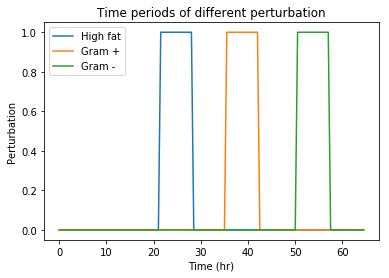

In [83]:
times_new = np.arange(0,times[-1]+0.5,0.5)
all_abs_amount_new = interpolate_series(all_abs_amount, times, times_new)
tree_healthy_amount_new = interpolate_series(tree_healthy, times, times_new)
NMF_healthy_amount_new = interpolate_series(NMF_healthy, times, times_new)
time_healthy_amount_new = interpolate_series(time_healthy, times, times_new)

# Also expand for perturbation
is_high_fat_new = np.logical_and(np.array(times_new)>=high_fat[0], np.array(times_new)<high_fat[1]) 
is_gram_pos_new = np.logical_and(np.array(times_new)>=gram_pos[0], np.array(times_new)<gram_pos[1]) 
is_gram_neg_new = np.logical_and(np.array(times_new)>=gram_neg[0], np.array(times_new)<gram_neg[1]) 
perturb = np.stack((is_high_fat_new, is_gram_pos_new, is_gram_neg_new),axis = 0)

plt.plot(times_new,is_high_fat_new,label = 'High fat')
plt.plot(times_new,is_gram_pos_new,label = 'Gram +')
plt.plot(times_new,is_gram_neg_new,label = 'Gram -')
plt.xlabel('Time (hr)')
plt.ylabel('Perturbation')
plt.legend()
plt.title('Time periods of different perturbation');

-------------------

## First model: RNN for modeling microbiome interactions

First, we would like to explore the idea that RNNs can be use to model non-linear dynamical systems with multiple variables, in our case, interactions between different species of bacteria (or OTUs). To learn the dynamics, we built a RNN with LSTM units that took time series of all OTUs (or clustered traces) as input, trained the network to predict the values of the "next time point" at every given time points. The concept is to treat RNN as a non-linear function approximator that operates on every given time to generate the next states of the microbiome.

-----------------------

### Structure of the networks

Here are 3 different network architectures. The first has an LSTM layer that received input sequences, an intermediate latent layer, and an output layer that maps to the dimension to the predicted sequences. The latent layer can be views as a place where that the dimensions of the whole dynamical system is reduced (to the number of units in that layer), and the output has to be a linear combination of those reduced factors. Therefore, this provides us an opportunity to study the dimensionality of data and potentially learn cluster structures by analyzing the activations in the latent space.

The second one omitted the latent layer and directly mapped to the output dimensions. This is more simplified and also is the one we tested in this notebook.

The third network contains 2 layers of LSTM layers, perhaps provide more capacity in solving complex non-linear dynamics.

In [82]:
def build_rnn(n_OTUs, latent_dim, max_len, n_node_lstm):
    model = Sequential()
    model.add(LSTM(n_node_lstm, return_sequences=True,input_shape=(max_len, n_OTUs)))
    model.add(TimeDistributed(Dense(latent_dim, activation = 'relu')))
    model.add(TimeDistributed(Dense(n_OTUs, activation = 'relu')))

    optimizer=Adam(lr=0.01)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

def build_rnn_no_latent(n_OTUs, max_len, n_node_lstm):
    model = Sequential()
    model.add(LSTM(n_node_lstm, return_sequences=True,input_shape=(max_len, n_OTUs)))
    model.add(TimeDistributed(Dense(n_OTUs, activation = 'relu')))

    optimizer=Adam(lr=0.01)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

def build_rnn_multilayer_no_latent(n_OTUs, max_len, n_node_lstm):
    model = Sequential()
    model.add(LSTM(n_node_lstm, return_sequences=True,input_shape=(max_len, n_OTUs)))
    model.add(LSTM(n_node_lstm, return_sequences=True,input_shape=(max_len, n_OTUs)))
    model.add(TimeDistributed(Dense(n_OTUs, activation = 'relu')))

    optimizer=Adam(lr=0.01)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

### Input

The input to the network is the time series of the absolute abundance of all OTUs normalized by the maximal values fir individual OTUs. Normalization put all the data into similar range and avoid imbalance loss between OTUs. 

To model the effect of different perturbations, we also feed in the indicator time series for each perturbation as input and let the network models the interactions between the perturbation and the OUTs.

In [421]:
data = all_abs_amount_new
nOTU = data[0].shape[0]
time_len = len(times_new)

all_seq = [np.concatenate((this_seq/np.max(this_seq,axis=1).reshape(-1,1),perturb),axis=0).T.reshape(1,time_len,nOTU+3) for this_seq in data]

In [61]:
n_OTUs = nOTU+3
latent_dim = 5
max_len = time_len-1
n_node_lstm = 16

healthy_model = build_rnn_no_latent(n_OTUs, max_len, n_node_lstm)
healthy_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 129, 16)           14208     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 129, 205)          3485      
Total params: 17,693
Trainable params: 17,693
Non-trainable params: 0
_________________________________________________________________


In [62]:
n_epochs = 200
healthy_losses = []
for n_epo in range(n_epochs):
    loss_epo = []
    for n_mouse, this_seq in enumerate(all_seq[:-1]):
        his_seq = this_seq + 0.1*np.random.normal(size=this_seq.shape)
        this_loss, _ = healthy_model.train_on_batch(this_seq[:,:-1,:], this_seq[:,1:,:])
        loss_epo.append(this_loss)
    healthy_losses.append(np.mean(loss_epo))
    if n_epo%10 == 9:
        print('epoch=', n_epo + 1, 'loss = ', healthy_losses[-1])

epoch= 10 loss =  0.016603818
epoch= 20 loss =  0.01212132
epoch= 30 loss =  0.009712082
epoch= 40 loss =  0.008166417
epoch= 50 loss =  0.007714294
epoch= 60 loss =  0.006811662
epoch= 70 loss =  0.0065339277
epoch= 80 loss =  0.006231099
epoch= 90 loss =  0.005914156
epoch= 100 loss =  0.005796844
epoch= 110 loss =  0.0055900034
epoch= 120 loss =  0.005727392
epoch= 130 loss =  0.0053022536
epoch= 140 loss =  0.0053472533
epoch= 150 loss =  0.00520156
epoch= 160 loss =  0.005228782
epoch= 170 loss =  0.0050038383
epoch= 180 loss =  0.005008803
epoch= 190 loss =  0.004983654
epoch= 200 loss =  0.0048853825


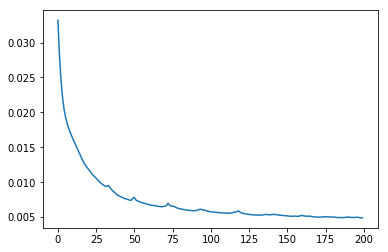

In [63]:
plt.plot(healthy_losses)

Check training loss and R^2 score.

In [115]:
healthy_train_loss = []
healthy_training_r2 = [] 
for seq in all_seq[:-1]:
    this_loss,_ = healthy_model.evaluate(seq[:,:-1,:],seq[:,1:,:], verbose = 0)
    healthy_train_loss.append(this_loss)
    
    this_pred = healthy_model.predict(seq[:,:-1,:])
    this_r2 = r2_score(seq[:,1:,:].flatten(), this_pred.flatten())
    healthy_training_r2.append(this_r2)
    
print('Mean train loss', np.mean(healthy_train_loss),
     '\nMean training R^2', np.mean(healthy_training_r2))


Mean train loss 0.004816598258912563 
Mean training R^2 0.8439080584791087


Here we tried to reconstruct the dynamics of first 5 OTUs in the first mouse.

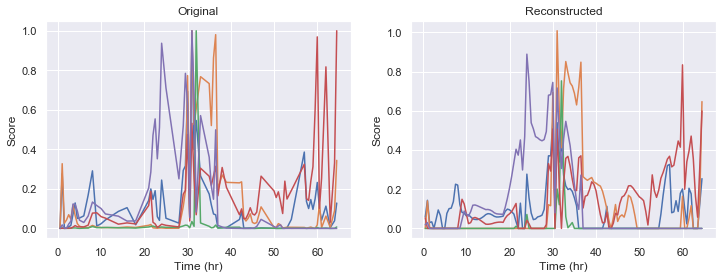

In [422]:
pred = healthy_model.predict(all_seq[0][:,:-1,:])

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(times_new[1:],all_seq[0][:,1:,:5].reshape(max_len,-1));
ax[0].set(title = 'Original', xlabel = 'Time (hr)', ylabel = 'Score')
ax[1].plot(times_new[1:],pred[0,:,:5])
ax[1].set(title = 'Reconstructed', xlabel = 'Time (hr)', ylabel = 'Score');

Now we turned to held-out mouse and check the test loss.

In [118]:
healthy_test_loss,_ = healthy_model.evaluate(all_seq[-1][:,:-1,:],all_seq[-1][:,1:,:],verbose = 0)
healthy_test_pred = healthy_model.predict(all_seq[-1][:,:-1,:])
healthy_test_r2 = r2_score(all_seq[-1][:,1:,:].flatten(),healthy_test_pred.flatten())
print('Test loss', healthy_test_loss, '\nTest R^2', healthy_test_r2)

Test loss 0.03130917251110077 
Test R^2 -0.13794000374208637


We can see that the loss on held-out sequence was really high compared to training sequence and the R^2 was -0.13. The model probably overfit on the training set and didn't do a good job on predicting the test data.

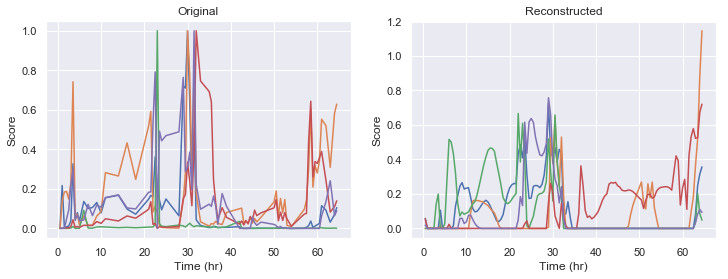

In [423]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(times_new[1:],all_seq[-1][:,1:,:5].reshape(max_len,-1));
ax[0].set(title = 'Original', xlabel = 'Time (hr)', ylabel = 'Score')
ax[1].plot(times_new[1:],healthy_test_pred[0,:,:5])
ax[1].set(title = 'Reconstructed', xlabel = 'Time (hr)', ylabel = 'Score');

The reconstructed time series on held-out data looked terrible.

## Model interactions on clustered data (with augmentation)

Since our model overfit on the original data, now we tried on clustered, augmented data. The thought is that with proper dimensionality reduction and augmentation, we should be able to avoid overfitting and recovered dynamics between the extracted time series of cluters.


### NMF-based clusters
First we tried on the NMF-based clusters on healthy mice. There are 9 clusters with 30 bootstrapped mice.

In [415]:
data = NMF_healthy_amount_new
nOTU = data[0].shape[0]
time_len = len(times_new)

all_seq = [np.concatenate((this_seq/np.max(this_seq,axis=1).reshape(-1,1),perturb),axis=0).T.reshape(1,time_len,nOTU+3) for this_seq in data]

In [28]:
# set up model
n_OTUs = nOTU+3
max_len = time_len-1
n_node_lstm = 16

NMF_healthymodel = build_rnn_no_latent(n_OTUs, max_len, n_node_lstm)
NMF_healthymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 129, 16)           1856      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 129, 12)           204       
Total params: 2,060
Trainable params: 2,060
Non-trainable params: 0
_________________________________________________________________


This time, we saved that last 3 samples as test set and only trained on the first 27 samples.

In [29]:
# training 
n_epochs = 200
NMF_healthy_losses = []
for n_epo in range(n_epochs):
    loss_epo = []
    for n_mouse, this_seq in enumerate(all_seq[:-3]):
        his_seq = this_seq + 0.1*np.random.normal(size=this_seq.shape)
        this_loss, _ = NMF_healthymodel.train_on_batch(this_seq[:,:-1,:], this_seq[:,1:,:])
        loss_epo.append(this_loss)
    NMF_healthy_losses.append(np.mean(loss_epo))
    if n_epo%10 == 9:
        print('epoch=', n_epo + 1, 'loss = ', NMF_healthy_losses[-1])

epoch= 10 loss =  0.038406715
epoch= 20 loss =  0.02020346
epoch= 30 loss =  0.0193568
epoch= 40 loss =  0.018636283
epoch= 50 loss =  0.018052446
epoch= 60 loss =  0.018466515
epoch= 70 loss =  0.017589964
epoch= 80 loss =  0.017770851
epoch= 90 loss =  0.017083503
epoch= 100 loss =  0.017414812
epoch= 110 loss =  0.01694359
epoch= 120 loss =  0.01712895
epoch= 130 loss =  0.016907193
epoch= 140 loss =  0.016500242
epoch= 150 loss =  0.016779764
epoch= 160 loss =  0.016482528
epoch= 170 loss =  0.016535766
epoch= 180 loss =  0.016417759
epoch= 190 loss =  0.016293015
epoch= 200 loss =  0.01615227


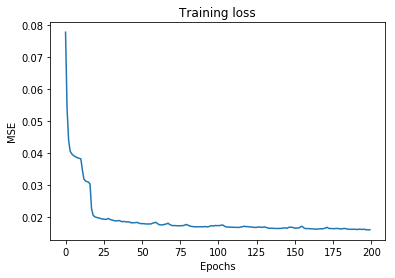

In [78]:
plt.plot(NMF_healthy_losses)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training loss');

Here we evaluated the final training loss.

In [121]:
NMF_healthy_training_loss = []
NMF_healthy_training_r2 = []
 
for seq in all_seq[:-3]:
    this_loss,_ = NMF_healthymodel.evaluate(seq[:,:-1,:],seq[:,1:,:],verbose = 0)
    NMF_healthy_training_loss.append(this_loss)
    
    this_pred = NMF_healthymodel.predict(seq[:,:-1,:])
    this_r2 = r2_score(seq[:,1:,:].flatten(), this_pred.flatten())
    NMF_healthy_training_r2.append(this_r2)
    
print('Mean training loss', np.mean(NMF_healthy_training_loss),
     '\nMean training R^2', np.mean(NMF_healthy_training_r2))

Mean training loss 0.016172449587395898 
Mean training R^2 0.8012936513315387


The R^2 score is 0.80.

We looked at the reconstructed 5 clusters on first mice. The model seemed to capture the dynamics prettry well.

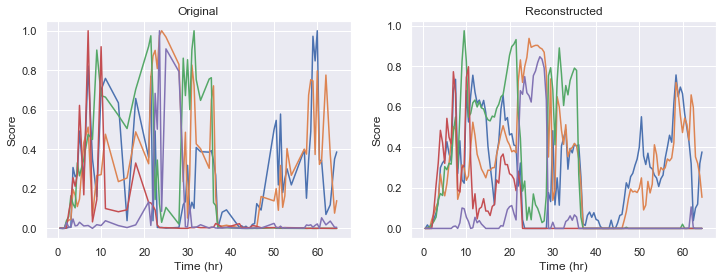

In [416]:
pred = NMF_healthymodel.predict(all_seq[0][:,:-1,:])

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(times_new[1:],all_seq[0][:,1:,3:8].reshape(max_len,-1));
ax[0].set(title = 'Original', xlabel = 'Time (hr)', ylabel = 'Score')
ax[1].plot(times_new[1:],pred[0,:,3:8])
ax[1].set(title = 'Reconstructed', xlabel = 'Time (hr)', ylabel = 'Score');

Next we evaluate on the held-out data.

In [122]:
NMF_healthy_test_loss = []
NMF_healthy_test_r2 = []
 
for seq in all_seq[-3:]:
    this_loss,_ = NMF_healthymodel.evaluate(seq[:,:-1,:],seq[:,1:,:], verbose = 0)
    NMF_healthy_test_loss.append(this_loss)
    
    this_pred = NMF_healthymodel.predict(seq[:,:-1,:])
    this_r2 = r2_score(seq[:,1:,:].flatten(), this_pred.flatten())
    NMF_healthy_test_r2.append(this_r2)
    
print('Mean test loss', np.mean(NMF_healthy_test_loss),
     '\nMean test R^2', np.mean(NMF_healthy_test_r2))


Mean test loss 0.019443864623705547 
Mean test R^2 0.7672814894909109


The MSE on the held-out data is slightly higher than the training loss and R^2 of 0.76, indicating that the model didn't overfit that much as the one using original data.

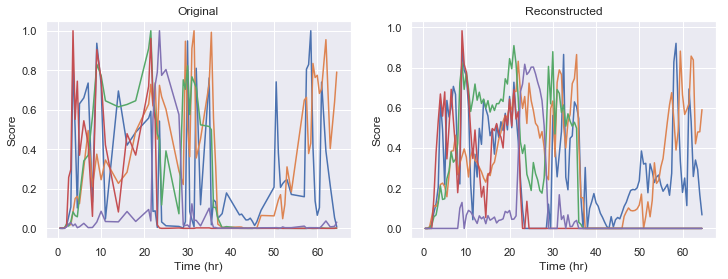

In [417]:
# reconstruct on one mouse of held-out data
NMF_health_pred = NMF_healthymodel.predict(all_seq[-2][:,:-1,:])

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(times_new[1:],all_seq[-2][:,1:,3:8].reshape(max_len,-1));
ax[0].set(title = 'Original', xlabel = 'Time (hr)', ylabel = 'Score')
ax[1].plot(times_new[1:],NMF_health_pred[0,:,3:8])
ax[1].set(title = 'Reconstructed', xlabel = 'Time (hr)', ylabel = 'Score');

Here we can see that the reconstructed time series (for 5 clusters) on one of the held-out series seemed similar to the original ones.

### Tree-based clusters

next we tried on the phylogenic tree-based clusters on healthy mice. There are 3 clusters with 30 bootstrapped mice.

In [418]:
data = tree_healthy_amount_new
nOTU = data[0].shape[0]
time_len = len(times_new)

all_seq = [np.concatenate((this_seq/np.max(this_seq,axis=1).reshape(-1,1),perturb),axis=0).T.reshape(1,time_len,nOTU+3) for this_seq in data]

In [89]:
# set up model
n_OTUs = nOTU+3
max_len = time_len-1
n_node_lstm = 16

tree_healthy_model = build_rnn_no_latent(n_OTUs, max_len, n_node_lstm)
tree_healthy_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 129, 16)           1472      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 129, 6)            102       
Total params: 1,574
Trainable params: 1,574
Non-trainable params: 0
_________________________________________________________________


In [90]:
# training 
n_epochs = 200
tree_healthy_losses = []
for n_epo in range(n_epochs):
    loss_epo = []
    for n_mouse, this_seq in enumerate(all_seq[:-3]):
        his_seq = this_seq + 0.1*np.random.normal(size=this_seq.shape)
        this_loss, _ = tree_healthy_model.train_on_batch(this_seq[:,:-1,:], this_seq[:,1:,:])
        loss_epo.append(this_loss)
    tree_healthy_losses.append(np.mean(loss_epo))
    if n_epo%10 == 9:
        print('epoch=', n_epo + 1, 'loss = ', tree_healthy_losses[-1])

epoch= 10 loss =  0.027044676
epoch= 20 loss =  0.025413064
epoch= 30 loss =  0.0070256535
epoch= 40 loss =  0.0060295262
epoch= 50 loss =  0.0052636755
epoch= 60 loss =  0.004702508
epoch= 70 loss =  0.0043166783
epoch= 80 loss =  0.0041318154
epoch= 90 loss =  0.005046212
epoch= 100 loss =  0.0042718593
epoch= 110 loss =  0.0043873833
epoch= 120 loss =  0.0037726357
epoch= 130 loss =  0.0036270102
epoch= 140 loss =  0.0038263416
epoch= 150 loss =  0.003657599
epoch= 160 loss =  0.0034978157
epoch= 170 loss =  0.0038525502
epoch= 180 loss =  0.0033362487
epoch= 190 loss =  0.003502469
epoch= 200 loss =  0.0030561348


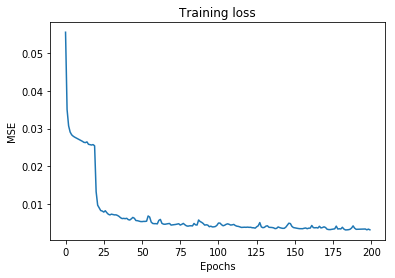

In [91]:
plt.plot(tree_healthy_losses)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training loss');

In [108]:
tree_healthy_training_loss = []
tree_healthy_training_r2 = []
 
for seq in all_seq[:-3]:
    this_loss,_ = tree_healthy_model.evaluate(seq[:,:-1,:],seq[:,1:,:],verbose = 0)
    tree_healthy_training_loss.append(this_loss)
    
    this_pred = tree_healthy_model.predict(seq[:,:-1,:])
    this_r2 = r2_score(seq[:,1:,:].flatten(), this_pred.flatten())
    tree_healthy_training_r2.append(this_r2)
    
print('Mean training loss', np.mean(tree_healthy_training_loss),
     '\nMean training R^2', np.mean(tree_healthy_training_r2))

Mean training loss 0.003381501960878571 
Mean training R^2 0.9554350227028825


The MSE of the training data is 0.003 while the R^2 score is 0.95.

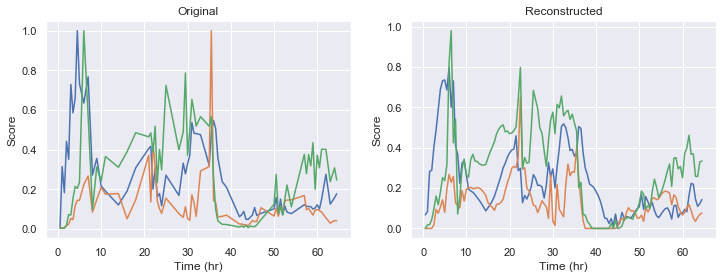

In [419]:
tree_healthy_train_pred = tree_healthy_model.predict(all_seq[0][:,:-1,:])

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(times_new[1:],all_seq[0][:,1:,:3].reshape(max_len,-1));
ax[0].set(title = 'Original', xlabel = 'Time (hr)', ylabel = 'Score')
ax[1].plot(times_new[1:],tree_healthy_train_pred[0,:,:3])
ax[1].set(title = 'Reconstructed', xlabel = 'Time (hr)', ylabel = 'Score');

In [112]:
tree_healthy_test_loss = []
tree_healthy_test_r2 = []
 
for seq in all_seq[-3:]:
    this_loss,_ = tree_healthy_model.evaluate(seq[:,:-1,:],seq[:,1:,:], verbose = 0)
    tree_healthy_test_loss.append(this_loss)
    
    this_pred = tree_healthy_model.predict(seq[:,:-1,:])
    this_r2 = r2_score(seq[:,1:,:].flatten(), this_pred.flatten())
    tree_healthy_test_r2.append(this_r2)
    
print('Mean test loss', np.mean(tree_healthy_test_loss),
     '\nMean test R^2', np.mean(tree_healthy_test_r2))

Mean test loss 0.0035608175676316023 
Mean test R^2 0.9544613650730905


The MSE of the test data is 0.003 while the R^2 score is 0.95, indicating that the model did learn the dynamics and didn't overfit.

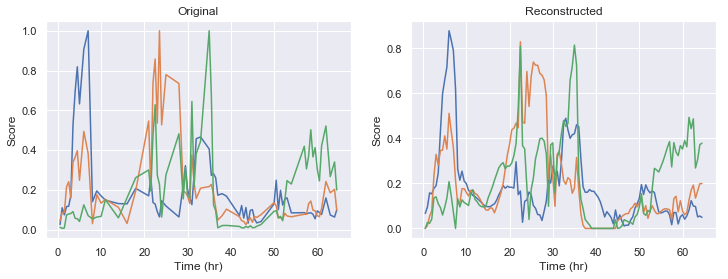

In [420]:
tree_healthy_test_pred = tree_healthy_model.predict(all_seq[-1][:,:-1,:])

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(times_new[1:],all_seq[-1][:,1:,:3].reshape(max_len,-1));
ax[0].set(title = 'Original', xlabel = 'Time (hr)', ylabel = 'Score')
ax[1].plot(times_new[1:],tree_healthy_test_pred[0,:,:3])
ax[1].set(title = 'Reconstructed', xlabel = 'Time (hr)', ylabel = 'Score');

The reconstructed time seires on one of the held-out data seemed pretty reliable.

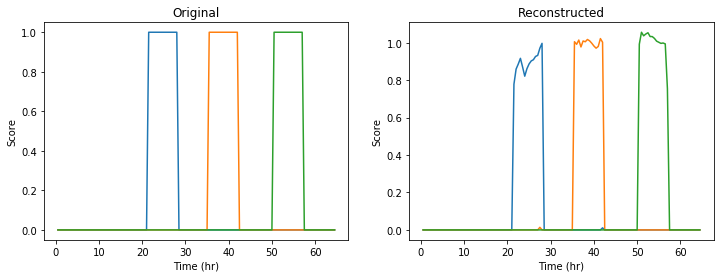

In [141]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(times_new[1:],all_seq[-1][:,1:,-3:].reshape(max_len,-1));
ax[0].set(title = 'Original', xlabel = 'Time (hr)', ylabel = 'Score')
ax[1].plot(times_new[1:],tree_healthy_test_pred[0,:,-3:])
ax[1].set(title = 'Reconstructed', xlabel = 'Time (hr)', ylabel = 'Score');

Interestingly, the model also was able to reconstruct the perturbations.

## Discussion and future direction

From the results above, we can see a proof of concepts of how to use RNNs to model non-linear dynamical systems and applied that to microbiome data. 

When we trained on the original time series, due to the high dimensionality and lack of training samples, the network overfit on the training set and generalize poorly on the held-out data. When we reduced the dimension of the data by various methods of  clustering and bootstrapped for clusters to create augmented data, we were able to trained networks that made preidctions on the dynamics and generalzied better on the test data, implying that the RNN can be a feasible tool to model non-linear dynamics.

One of the difficulty of modeling with RNN is that we don't have good interpretability of the dynamics. However, one can perhaps interrogate the dynamics by simulating the trajectories of the states of the network by making predictions on various initial conditions. For instance, we can manipulate the value of one given OTU/cluster while fixing the others, and observe the changes of the next states. By systemically exploring the plausible initial states in the biologically-plausible space, we can indirectly infer the non-linear interaction of the system.

Followed from that, a potential use of the model would be to apply it to make predictions one microbiome status after infections or treatment. By measuring the baseline state of the microbiome and changing the values of a specific species (such as some infectious bacteria) or a treatment (antibiotics), we can simulate the trajectories to predict the effect. I fthe network really learns the true dynamics, one ca potentially do multiple steps of prediciton: feed in data on time point t, make prediction on t+1, take the predictive values as next input to make further prediction on t+2, recursively. If new measurements were taken, one can replace the input with actual data to calibrate the network states. 


-------------------------

## Second model: Sequential VAE for state estimation

The second model is a sequential autoencoder. We extended the idea that RNNs can be used to model non-linear dynamical systems, and ask if we can construct an autoencoder to both capture the "dynamics" of the system, and condense the "state" of the system into a latent dimension, which represents the initial points that generate the time series of a period of time. The states here should correspond to different periods in the experiment, such as baseline, high fat, antibiotics, etc., or different health states of an animal. 

The autoencoder has a symetric structure. The encoder extracts information about the time series and represent every snippet of data as single values in the latent space, and the decoder uses the latent space representations as an initial points to generate the time series. Our hypothesis is that this model would both learn the dynamics as well as represntation of microbiome states, and we should be able to observed clusters in the latent states that correspond to different periods of the experiment (although not explicitly specified during the model training).

-----------------------

First we broke up the whole time series into snippets (each contained 7 time points), and every snippet belonged to only one experimental condition.

In [159]:
# breaking up time series into snippets
baseline_init = np.arange(0,44-7,3)
high_fat_init = np.arange(43,58-7,3)
interval1_init = np.arange(57,72-7,3)
gram_pos_init = np.arange(71,86-7,3)
interval2_init = np.arange(85,102-7,3)
gram_neg_init = np.arange(101,116-7,3)
interval3_init = np.arange(115,130-7,3)

init_idx = np.concatenate((baseline_init,high_fat_init, interval1_init, gram_pos_init,\
                           interval2_init, gram_neg_init, interval3_init), axis = 0)
slice_idx = [[idx, idx+7] for idx in init_idx]

label = np.concatenate((np.zeros(shape = baseline_init.shape),
                        np.ones(shape = high_fat_init.shape),
                        2*np.ones(shape = interval1_init.shape),
                        3*np.ones(shape = gram_pos_init.shape),
                        4*np.ones(shape = interval2_init.shape),
                        5*np.ones(shape = gram_neg_init.shape),
                        6*np.ones(shape = interval3_init.shape)), axis = 0)

Collect all snippets.

In [370]:
all_slices = []
all_labels = []
for this_seq in all_abs_amount_new:
    this_seq = this_seq/np.max(this_seq,axis=1).reshape(-1,1)
    these_slices = []
    for s in slice_idx:
        this_slice = this_seq[:, s[0]:s[1]].T
        these_slices.append(this_slice)
    these_slices = np.stack(these_slices, axis = 0)
    all_slices.append(these_slices)
    all_labels.append(label)
    
all_slices = np.concatenate(all_slices, axis = 0)
all_labels = np.concatenate(all_labels, axis = 0)

Break the whole dataset into trainn and test sets.

In [372]:
n_samples = all_slices.shape[0]
n_test = 32

test_idx = np.random.choice(all_slices.shape[0],n_test,replace=False)
train_idx = np.array(list(set(np.arange(n_samples))-set(test_idx)))

X_train = all_slices[train_idx,:,:]
X_test = all_slices[test_idx,:,:]
y_train = all_labels[train_idx]
y_test = all_labels[test_idx]

Perform some data augmentation by adding random noise into the training data.

In [373]:
n_fold = 20

X_train_aug = []
X_train_rep = []
y_train_aug = []

for i in range(n_fold):
    perm_idx = np.random.choice(X_train.shape[0],X_train.shape[0],replace=False)
    this_aug = X_train + 0.01*np.random.normal(size=X_train.shape)
    X_train_aug.append(this_aug[perm_idx,:,:])
    X_train_rep.append(X_train[perm_idx,:,:])
    y_train_aug.append(y_train[perm_idx])
X_train_aug = np.concatenate(X_train_aug,axis=0)
X_train_rep = np.concatenate(X_train_rep,axis=0)
y_train_aug = np.concatenate(y_train_aug,axis=0)
X_train_aug.shape

(1920, 7, 202)

### LSTM-VAE

Here we define the structure of the LSTM-VAE. We added a latent dense layer before mapping onto output layer. The idea is the same as that mentioned above. It provided us a way to perhaps investigate cluster structures of the data by assuming that the output time series are a linear combination of those latent nodes of reduced dimension. Since the number of parameters is massive in this network, we also added dropout in the LSTM layers as a proxy of Bayesian networks, to provide regularization and avoid overfitting.

In [383]:
def create_lstm_vae(input_dim, 
    timesteps, 
    batch_size, 
    intermediate_dim, 
    latent_dim,
    latent_fac):

    x = Input(shape=(timesteps, input_dim,))

    # LSTM encoding
    h = LSTM(intermediate_dim, dropout = 0.1, recurrent_dropout = 0.1)(x)

    # VAE Z layer
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim),
                                  mean=0., stddev=1.)
        return z_mean + z_log_sigma * epsilon

    # latent layer
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    # decoded LSTM layer
    decoder_h1 = LSTM(intermediate_dim, return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1)
    decoder_h2 = Dense(latent_fac, activation = 'relu')
    decoder_out = Dense(input_dim, activation = 'relu')

    h_decoded = RepeatVector(timesteps)(z)
    h_decoded = decoder_h1(h_decoded)

    # decoded layer
    h_decoded = decoder_h2(h_decoded)
    x_decoded_out = decoder_out(h_decoded)
    
    # vae
    vae = Model(x, x_decoded_out)

    # encoder
    encoder = Model(x, z_mean)

    # generator
    decoder_input = Input(shape=(latent_dim,))

    _h_decoded = RepeatVector(timesteps)(decoder_input)
    _h_decoded = decoder_h1(_h_decoded)
    _h_decoded = decoder_h2(_h_decoded)

    _x_decoded_out = decoder_out(_h_decoded)
    generator = Model(decoder_input, _x_decoded_out)
    
    def vae_loss(x, x_decoded_out):
        xent_loss = objectives.mse(x, x_decoded_out)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss
        return loss

    optimizer=Adam(lr=0.01)
    vae.compile(optimizer=optimizer, loss=vae_loss, metrics=['mse'])
    
    return vae, encoder, generator

Build and train the LSTM-VAE.

In [404]:
n_epochs = 50

input_dim = 202
timesteps = 7
batch_size = 32
intermediate_dim = 10
latent_dim = 5
latent_fac = 5

# build vae
vae, encoder, generator = create_lstm_vae(input_dim, 
    timesteps, 
    batch_size, 
    intermediate_dim, 
    latent_dim,
    latent_fac)

vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           (None, 7, 202)       0                                            
__________________________________________________________________________________________________
lstm_49 (LSTM)                  (None, 10)           8520        input_41[0][0]                   
__________________________________________________________________________________________________
dense_91 (Dense)                (None, 5)            55          lstm_49[0][0]                    
__________________________________________________________________________________________________
dense_92 (Dense)                (None, 5)            55          lstm_49[0][0]                    
__________________________________________________________________________________________________
lambda_21 

In [405]:
# Training
history = vae.fit(X_train_aug,X_train_aug,batch_size=batch_size, epochs=n_epochs, verbose=1, shuffle=False)

Epoch 1/50
1920/1920 [==============================] - 9s 5ms/step - loss: 0.0280 - mean_squared_error: 0.0269
Epoch 2/50
1920/1920 [==============================] - 2s 914us/step - loss: 0.0246 - mean_squared_error: 0.0244
Epoch 3/50
1920/1920 [==============================] - 2s 877us/step - loss: 0.0230 - mean_squared_error: 0.0226
Epoch 4/50
1920/1920 [==============================] - 2s 982us/step - loss: 0.0217 - mean_squared_error: 0.0213
Epoch 5/50
1920/1920 [==============================] - 2s 973us/step - loss: 0.0213 - mean_squared_error: 0.0209
Epoch 6/50
1920/1920 [==============================] - 2s 845us/step - loss: 0.0210 - mean_squared_error: 0.0206
Epoch 7/50
1920/1920 [==============================] - 2s 891us/step - loss: 0.0207 - mean_squared_error: 0.0203
Epoch 8/50
1920/1920 [==============================] - 2s 856us/step - loss: 0.0205 - mean_squared_error: 0.0199
Epoch 9/50
1920/1920 [==============================] - 2s 985us/step - loss: 0.0203 - mea

Plot the loss over the training process.

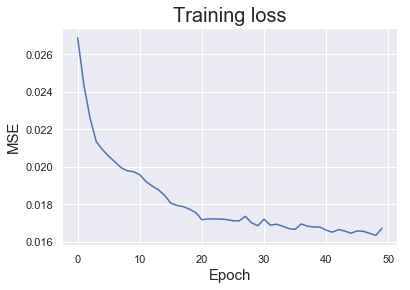

In [409]:
plt.plot(history.history['mean_squared_error'])
plt.title('Training loss',fontsize = 20)
plt.xlabel('Epoch',fontsize = 15)
plt.ylabel('MSE',fontsize = 15);

In [410]:
vae_train_loss = []
vae_train_r2 = []

for i in range(int(X_train_aug.shape[0]/batch_size)):
    this_x = X_train_aug[i*batch_size: i*batch_size+batch_size]
    this_loss,_ = vae.evaluate(this_x, this_x, verbose = 0)
    vae_train_loss.append(this_loss)
    
    this_pred = vae.predict(this_x)
    this_r2 = r2_score(this_x.flatten(), this_pred.flatten())
    vae_train_r2.append(this_r2)
    
print('Mean train loss', np.mean(vae_train_loss),
     '\nMean training R^2', np.mean(vae_train_r2))

Mean train loss 0.01661167531274259 
Mean training R^2 0.4103012739078286


The loss on training set is 0.016, with R2 score 0.41.

In [411]:
vae_test_loss, _ = vae.evaluate(X_test, X_test, verbose = 0)
vae_test_pred = vae.predict(X_test)
vae_test_r2 = r2_score(X_test.flatten(), vae_test_pred.flatten())

print('Mean test loss', np.mean(vae_test_loss),
     '\nMean test R^2', np.mean(vae_test_r2))

Mean test loss 0.019366877153515816 
Mean test R^2 0.2498650881782969


The loss on test set is 0.019, with R2 score 0.24. The model overfit a little bit but we can see some generalization on the test set. 

### Encoding of the latent states

Here we checked the latent state representation.

In [391]:
latent_x = []
all_x = np.concatenate((X_train_aug,X_test), axis = 0)
all_y = np.concatenate((y_train_aug,y_test), axis = 0)

for i in range(int(all_x.shape[0]/batch_size)): 
    this_lat = encoder.predict(all_x[i*batch_size:i*batch_size+batch_size,:,:])
    latent_x.append(this_lat)
latent_x = np.concatenate(latent_x, axis=0)

Plot distribution of encoded data in the latent space (first 2 dimensions).

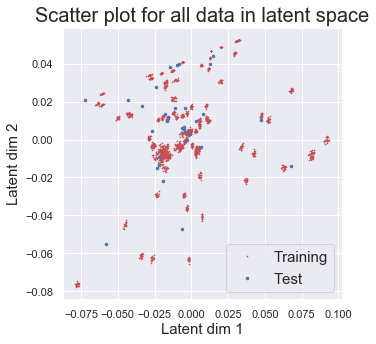

In [395]:
sns.set()
plt.figure(figsize = (5,5))
plt.plot(latent_x[:-batch_size,0],latent_x[:-batch_size,1],'rx', markersize = 1, label = 'Training')
plt.plot(latent_x[-batch_size:,0],latent_x[-batch_size:,1],'b.', markersize = 5, label = 'Test')
plt.legend(fontsize = 15)
plt.xlabel('Latent dim 1',fontsize = 15)
plt.ylabel('Latent dim 2',fontsize = 15)
plt.title('Scatter plot for all data in latent space',fontsize = 20);

To view the full dimension, we used tSNE to create embedding in 2D space.

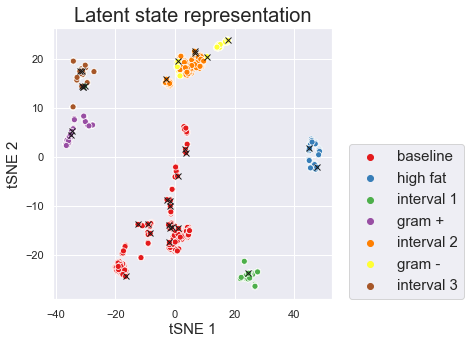

In [382]:
label_dict = {0.:'baseline', 1.: 'high fat', 2.: 'interval 1', 3.: 'gram +', 4.:'interval 2', 5.:'gram -', 6.: 'interval 3'} 
label_names = [label_dict[lab] for lab in all_y]

# tSNE 
X_embedded = TSNE(n_components=2,perplexity=100).fit_transform(latent_x)

plt.figure(figsize = (5,5))

sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue = label_names, palette='Set1', legend='full',
                hue_order = ['baseline','high fat','interval 1','gram +','interval 2','gram -','interval 3'])
plt.plot(X_embedded[-batch_size:,0], X_embedded[-batch_size:,1],'kx')
plt.title('Latent state representation',fontsize = 20);
plt.xlabel('tSNE 1',fontsize = 15)
plt.ylabel('tSNE 2',fontsize = 15)
plt.legend(bbox_to_anchor=(1., 0.1, 0.5, 0.5),fontsize = 15);

Test data is marked with black crosses.

As we can see from the above visualization, time series that belonged to the same experimental periods tend to cluster together, even if this information was not provided. The network learned to represent microbiome states as a stationary initial condition that can be used to reconstruct the full time series.  

## Discussion and future work

The LSTM-VAE is another way of modeling dynamics of time series data. It learns to represent the "states" of the data as well as generating time series using the state as initial conditions. Our work is an initial attempt as a proof-of-concept. 

Two extension can be added onto the data. The latent dense layer added before output layer can serve as a place for dimensionality reduction. By analyzing the weights between the latent dense layer and output units, one might be able to extract clustering information about the full set of microbiomes. Another extension would be to add in extract module parallel to encoders as a network that extract information about "perturbation", and allow the perturbation to modulate the decoder to generate time series. 

The LSTM-VAE would be useful to infer the health states of patients/animals by clustering the latent representation. For examples, we can collect data after a treatment and see if the microbiome state returned to baseline as a clinical assesement.

